In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import anchors
from poola import core as pool


import core_functions as fns

gpp.set_aesthetics(palette='Set2')


## Functions

In [3]:
## Data Cleaning  

def get_grouped_controls(df, control_name):
    '''
    Inputs:
    1. df: guide-gene annotation df 
    2. control_name: list of string identifiers for controls 
    Outputs:
    1. grouped_controls: controls grouped into pseudogenes with 3 random controls from Library A and Library B, each
    '''
    ungrouped_df = pd.DataFrame()
    for control in control_name:
        control_condition = (df['Gene Symbol'].str.contains(control))
        control_rows = df[control_condition]
        #if all controls have same Gene Symbol
        if len(set(control_rows['Gene Symbol'])) == 1:
            ungrouped_df = df.copy()
            # Give controls unique names before grouping 
            ungrouped_df.loc[control_condition, 'Gene Symbol'] = control + control_rows['Guide'] 
   
    LibA_ungrouped_genes = ungrouped_df[ungrouped_df['Guide'].str.contains('LibA')]

    LibA_grouped_genes = pool.group_pseudogenes(LibA_ungrouped_genes[['Guide', 'Gene Symbol']], pseudogene_size=3, gene_col='Gene Symbol', control_regex = control_name)

    LibB_ungrouped_genes = ungrouped_df[ungrouped_df['Guide'].str.contains('LibB')]
    LibB_grouped_genes = pool.group_pseudogenes(LibB_ungrouped_genes[['Guide', 'Gene Symbol']], pseudogene_size=3, gene_col='Gene Symbol', control_regex = control_name)

    grouped_controls = pd.concat([LibA_grouped_genes, LibB_grouped_genes])

    return grouped_controls

    
def match_pseudogenes(df, guide_mapping, control_name):
    '''
    Inputs: 
    1. df: data frame to which grouped pseudogene annotations will be merged 
    2. guide_mapping: guide-gene annotation data frame
    3. control_name: list containing substrings that identify controls 
    '''
    grouped_genes = get_grouped_controls(guide_mapping, control_name)
    grouped_df = pd.merge(grouped_genes, df, on = 'Guide', how = 'outer', suffixes = ['', '_old'])
    grouped_df.loc[:,'Gene Symbol'] = grouped_df.loc[:,'Gene Symbol'].fillna(grouped_df['Gene Symbol_old'])
    grouped_df = grouped_df.drop('Gene Symbol_old', axis = 1)

    return grouped_df

## Data Summary

* Daniloski et al.
* Cell line: A549 (overexpressing ACE2)
* Library: GeCKOv2

In [5]:
# Reads from GEO Submission GSE175666 
reads = pd.read_excel('Data/GSE175666_A549_GeCKOv2_Sanjana_v2.xlsx', sheet_name = 'A549_GeCKOv2_genomewide_reads')
reads

,Guide,Gene Symbol,pDNA,control,MOI1,MOI3
0,HGLibA_00001,A1BG,467,296,139,199
1,HGLibA_00002,A1BG,417,269,782,356
2,HGLibA_00003,A1BG,981,942,1641,1563
3,HGLibA_00004,A1CF,170,220,170,275
4,HGLibA_00005,A1CF,599,418,402,344
...,...,...,...,...,...,...
123399,HGLibB_58025,NonTargeting_181,694,398,40,226
123400,HGLibB_58026,NonTargeting_63,1676,2186,1914,1938
123401,HGLibB_58027,NonTargeting_154,460,378,187,406
123402,HGLibB_58028,NonTargeting_112,648,739,851,586


In [6]:
#Calculate lognorm

cols = reads.columns[2:].to_list() #reads columns are 3rd and 4th in df
lognorms = fns.get_lognorm(reads.dropna(), cols = cols)
lognorms


,Guide,Gene Symbol,pDNA_lognorm,control_lognorm,MOI1_lognorm,MOI3_lognorm
0,HGLibA_00001,A1BG,2.956451,2.494172,1.672900,2.195072
1,HGLibA_00002,A1BG,2.815192,2.381657,3.734715,2.888082
2,HGLibA_00003,A1BG,3.926455,3.977056,4.746176,4.863513
3,HGLibA_00004,A1CF,1.791433,2.151932,1.878389,2.571926
4,HGLibA_00005,A1CF,3.274034,2.915336,2.873709,2.845396
...,...,...,...,...,...,...
123399,HGLibB_58025,NonTargeting_181,3.465852,2.854179,0.704693,2.340487
123400,HGLibB_58026,NonTargeting_63,4.659259,5.138450,4.960504,5.164143
123401,HGLibB_58027,NonTargeting_154,2.937488,2.790315,1.979771,3.053482
123402,HGLibB_58028,NonTargeting_112,3.376150,3.651852,3.847892,3.528513


## Quality Control

### Population Distributions

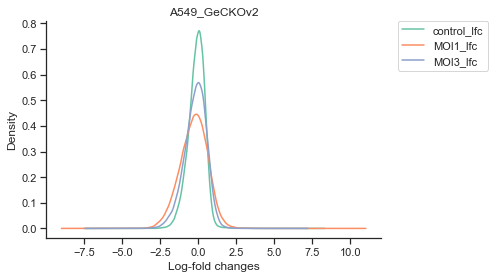

In [7]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols, ref_col='pDNA_lognorm')
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, initial_id='control', res_id='MOI', filename = 'A549_GeCKOv2')

### Control Distributions

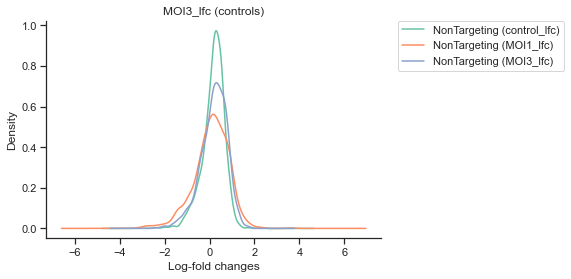

In [8]:
#Plot control distributions (non-targeting) of log-fold changes 
fns.control_dist_plot(pDNA_lfc, control_name=['NonTargeting'],initial_id='control', res_id='MOI', filename='A549_GeCKOv2')

### ROC-AUC

Text(0, 0.5, 'True Positive Rate (essential)')

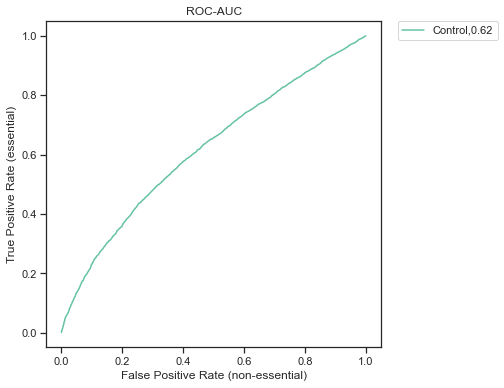

In [9]:
ess_genes, non_ess_genes = fns.get_gene_sets()

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col='control_lfc')    

fig,ax=plt.subplots(figsize=(6,6))
ax=sns.lineplot(data=roc_df, x='fpr',y='tpr', ci=None, label = 'Control,' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene-level analysis

### Residual z-scores

In [10]:
#Calculate z-scores of lfc residuals
lfc_df = pDNA_lfc.copy().drop(['Gene Symbol'], axis = 1)
lfc_df = lfc_df.dropna()

guide_residuals_lfcs, all_model_info, model_fit_plots = fns.run_guide_residuals(lfc_df, initial_id='control', res_id='MOI')

guide_mapping = pDNA_lfc[['Guide', 'Gene Symbol']]

gene_residuals = anchors.get_gene_residuals(guide_residuals_lfcs, guide_mapping)
gene_residuals

   modified  unperturbed
0  MOI1_lfc  control_lfc
1  MOI3_lfc  control_lfc


,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,MOI1_lfc,A1BG,6,0.493057,0.097620,1.883962,0.059570,0.879266
1,MOI1_lfc,A1CF,6,-0.215422,-0.234928,0.588160,0.556425,0.988653
2,MOI1_lfc,A2M,6,-0.038198,-0.119101,0.656315,0.511622,0.983684
3,MOI1_lfc,A2ML1,6,-0.371951,-0.600611,0.804771,0.420952,0.977024
4,MOI1_lfc,A3GALT2,6,0.182240,-0.014833,1.228072,0.219420,0.943704
...,...,...,...,...,...,...,...,...
42453,MOI3_lfc,hsa-mir-95,4,0.360524,-0.064223,1.537807,0.124096,0.850600
42454,MOI3_lfc,hsa-mir-96,4,0.038926,0.439119,-0.475075,0.634733,0.976357
42455,MOI3_lfc,hsa-mir-98,4,-0.727895,-0.470157,-0.947452,0.343408,0.939489
42456,MOI3_lfc,hsa-mir-99a,4,-0.211731,0.364364,-1.161995,0.245237,0.914862


In [11]:
gene_residual_sheet= fns.format_gene_residuals(gene_residuals, guide_min = 5, guide_max = 7)
guide_residual_sheet = pd.merge(guide_mapping, guide_residuals_lfcs, on = 'Guide', how = 'outer')
guide_residual_sheet

['MOI1_lfc', 'MOI3_lfc']
MOI1_lfc
MOI3_lfc


,Guide,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,HGLibA_00001,A1BG,MOI1_lfc,-0.766250,-0.944604,control_lfc,-1.283552,-0.462279
1,HGLibA_00001,A1BG,MOI3_lfc,-0.358504,-0.579875,control_lfc,-0.761380,-0.462279
2,HGLibA_00002,A1BG,MOI1_lfc,1.413231,1.742178,control_lfc,0.919524,-0.433534
3,HGLibA_00002,A1BG,MOI3_lfc,0.452275,0.731549,control_lfc,0.072890,-0.433534
4,HGLibA_00003,A1BG,MOI1_lfc,0.938232,1.156617,control_lfc,0.819721,0.050601
...,...,...,...,...,...,...,...,...
246803,HGLibB_58027,NonTargeting_154,MOI3_lfc,0.277240,0.448432,control_lfc,0.115994,-0.147173
246804,HGLibB_58028,NonTargeting_112,MOI1_lfc,0.448903,0.553391,control_lfc,0.471742,0.275702
246805,HGLibB_58028,NonTargeting_112,MOI3_lfc,0.026851,0.043431,control_lfc,0.152363,0.275702
246806,HGLibB_40668,RCSD1,MOI1_lfc,0.107720,0.132794,control_lfc,0.000000,0.066216
